In [1]:
!pip install pyvi

     ---------------------------------------- 8.5/8.5 MB 17.4 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 30.5 MB/s eta 0:00:00
     --------------------------------------- 12.6/12.6 MB 40.9 MB/s eta 0:00:00
     --------------------------------------- 38.7/38.7 MB 31.2 MB/s eta 0:00:00
     ---------------------------------------- 309.1/309.1 kB ? eta 0:00:00
     ---------------------------------------- 301.9/301.9 kB ? eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer

from pyvi import ViTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

MÁY HỌC

In [4]:
df = pd.read_csv("film_cleaned_ver2.csv")
df["tokenized_text"] = df["cleaned_text"].apply(
    lambda x: ViTokenizer.tokenize(x)
)
dfML = df[df["label"].isin(
    ["negative", "mixed/neutral", "positive"]
)].copy()
dfML['tokenized_text'].head()

0    ta nói nó hài bản_thân tôi con_gái nhưng rất t...
1    hên coi ở cgv phim gì nhân_vật nói chả nghe cá...
2    phim hài cười banh rạp = nửa tiếng đầu mình bi...
3    nếu bỏ tiền mua vé xem phim việt tui tốn chưa ...
4    phim hay ý_nghĩa cười rất nhiều có nhìu hành_đ...
Name: tokenized_text, dtype: object

In [5]:
df.shape

(5409, 10)

In [6]:
X = dfML["tokenized_text"]
y = dfML["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [7]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_macro = make_scorer(f1_score, average="macro")

In [8]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [9]:
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_features": [10000, 20000, 30000]
}

In [10]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [10000, 20000, 30000],
                         'tfidf__min_df': [3, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

In [11]:
df_tfidf_cv = pd.DataFrame(grid.cv_results_)
df_tfidf_cv["ngram"] = df_tfidf_cv["params"].apply(lambda x: x["tfidf__ngram_range"])
df_tfidf_cv["min_df"] = df_tfidf_cv["params"].apply(lambda x: x["tfidf__min_df"])
df_tfidf_cv["max_features"] = df_tfidf_cv["params"].apply(lambda x: x["tfidf__max_features"])
df_tfidf_cv["mean_f1"] = df_tfidf_cv["mean_test_score"]


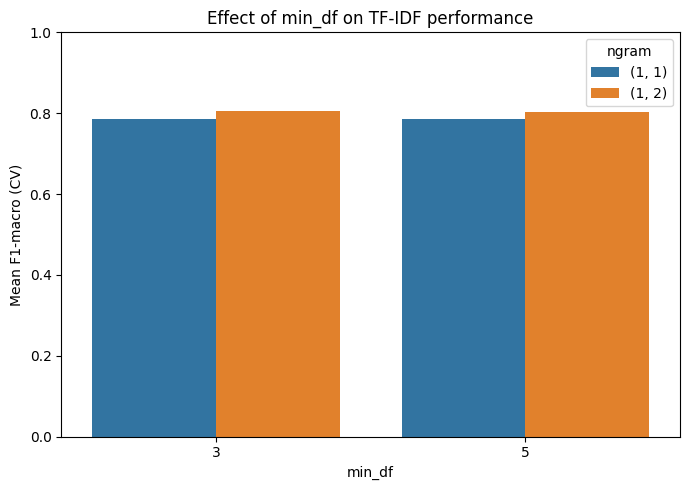

In [12]:
plt.figure(figsize=(7,5))

sns.barplot(
    data=df_tfidf_cv,
    x="min_df",
    y="mean_f1",
    hue="ngram"
)

plt.xlabel("min_df")
plt.ylabel("Mean F1-macro (CV)")
plt.title("Effect of min_df on TF-IDF performance")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [13]:
df_tfidf_cv[
    ["ngram", "min_df", "max_features", "mean_f1", "rank_test_score"]
].sort_values("mean_f1", ascending=False)


,ngram,min_df,max_features,mean_f1,rank_test_score
1,"(1, 2)",3,10000,0.806083,1
5,"(1, 2)",3,20000,0.806083,1
9,"(1, 2)",3,30000,0.806083,1
3,"(1, 2)",5,10000,0.803291,4
11,"(1, 2)",5,30000,0.803291,4
7,"(1, 2)",5,20000,0.803291,4
8,"(1, 1)",3,30000,0.786754,7
0,"(1, 1)",3,10000,0.786754,7
4,"(1, 1)",3,20000,0.786754,7
2,"(1, 1)",5,10000,0.785726,10


In [14]:
print("TF-IDF TUNING RESULT")
print("Best params:")
print(grid.best_params_)
print("\n Best score:")
print(grid.best_score_)

TF-IDF TUNING RESULT
Best params:
{'tfidf__max_features': 10000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}

 Best score:
0.8060825860546575


In [15]:
best_tfidf_params = {
    "ngram_range": (1, 2),
    "min_df": 3,
    "max_features": 10000
}

### Logistics Regression Tuning

In [16]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_macro": f1_score(y_test, y_pred, average="macro")
    }

In [17]:
pipe_lr_base = Pipeline([
    ("tfidf", TfidfVectorizer(**best_tfidf_params)),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

pipe_lr_base.fit(X_train, y_train)

lr_base_result = evaluate_model(pipe_lr_base, X_test, y_test)
lr_base_result

{'Accuracy': 0.7923228346456693, 'F1_macro': 0.7796054934502262}

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    pipe_lr_base,
    param_grid_lr,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        min_df=3,
                                                        ngram_range=(1, 2))),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'],
                         'clf__solver': ['liblinear', 'lbfgs']},
             scoring='f1_macro')

In [19]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)

{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
0.8060825860546575


In [20]:
df_lr_cv = pd.DataFrame(grid_lr.cv_results_)

df_lr_cv = df_lr_cv[
    [
        "params",
        "mean_test_score",
        "std_test_score",
        "rank_test_score"
    ]
].sort_values("rank_test_score")

df_lr_cv

,params,mean_test_score,std_test_score,rank_test_score
5,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.806083,0.017393,1
4,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.804317,0.015907,2
6,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...",0.795924,0.017138,3
7,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...",0.794229,0.017096,4
3,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...",0.792695,0.016365,5
2,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...",0.782279,0.015689,6
1,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...",0.775356,0.014994,7
0,"{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__s...",0.549257,0.014340,8


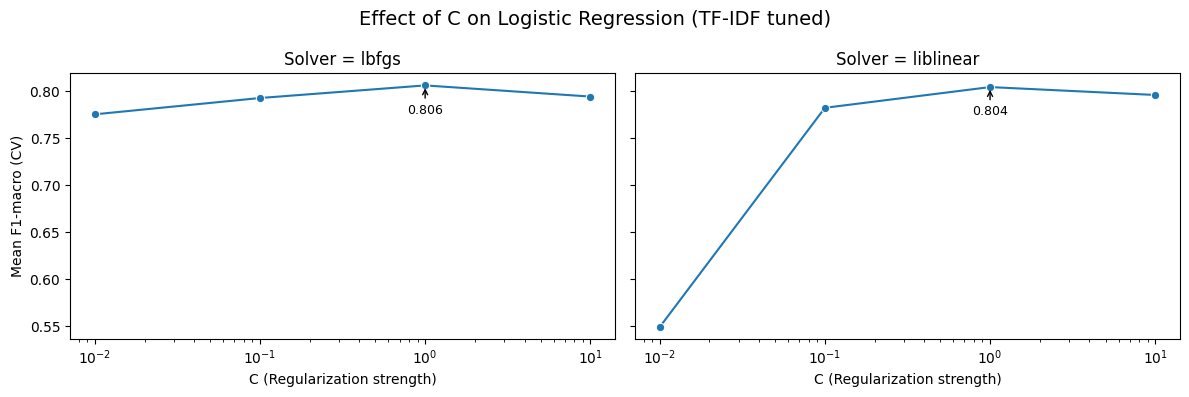

In [21]:
df_lr_cv["C"] = df_lr_cv["params"].apply(lambda x: x["clf__C"])
df_lr_cv["solver"] = df_lr_cv["params"].apply(lambda x: x["clf__solver"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

solvers = ["lbfgs", "liblinear"]

for ax, solver in zip(axes, solvers):
    data_solver = df_lr_cv[df_lr_cv["solver"] == solver]

    sns.lineplot(
        data=data_solver,
        x="C",
        y="mean_test_score",
        marker="o",
        ax=ax
    )

    ax.set_xscale("log")
    ax.set_title(f"Solver = {solver}")
    ax.set_xlabel("C (Regularization strength)")
    ax.set_ylabel("Mean F1-macro (CV)")

    # ===== ANNOTATE ĐIỂM C = 1 =====
    best_point = data_solver[data_solver["C"] == 1].iloc[0]
    best_c = best_point["C"]
    best_score = best_point["mean_test_score"]

    ax.annotate(
        f"{best_score:.3f}",
        xy=(best_c, best_score),
        xytext=(best_c, best_score - 0.03),
        arrowprops=dict(arrowstyle="->"),
        ha="center",
        fontsize=9
    )

plt.suptitle("Effect of C on Logistic Regression (TF-IDF tuned)", fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
#Thử trên tập test
lr_tuned_result = evaluate_model(
    grid_lr.best_estimator_,
    X_test,
    y_test
)
lr_tuned_result

{'Accuracy': 0.7923228346456693, 'F1_macro': 0.7796054934502262}

In [23]:
df_lr_compare = pd.DataFrame([
    {"Model": "Logistic Regression (baseline)", **lr_base_result},
    {"Model": "Logistic Regression (tuned)", **lr_tuned_result}
])

df_lr_compare

,Model,Accuracy,F1_macro
0,Logistic Regression (baseline),0.792323,0.779605
1,Logistic Regression (tuned),0.792323,0.779605


Phân tích ảnh hưởng các các từ (feature)

In [24]:
# Lấy vectorizer và model từ pipeline
tfidf = pipe_lr_base.named_steps["tfidf"]
clf = pipe_lr_base.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())

coef = clf.coef_
classes = clf.classes_

In [25]:
top_n = 20

neg_idx = np.where(classes == "negative")[0][0]
top_neg = np.argsort(coef[neg_idx])[-top_n:]

pd.DataFrame({
    "feature": feature_names[top_neg],
    "weight": coef[neg_idx][top_neg]
}).sort_values(by="weight", ascending=False)

,feature,weight
19,dở,3.856422
18,chán,2.906791
17,tệ,2.708163
16,không,2.568805
15,tiền,2.328948
14,thất_vọng,2.230524
13,nhạt,2.199034
12,không hay,2.054672
11,phí,1.868847
10,chả,1.787734


In [26]:
mix_idx = np.where(classes == "mixed/neutral")[0][0]
top_mix = np.argsort(coef[mix_idx])[-top_n:]

pd.DataFrame({
    "feature": feature_names[top_mix],
    "weight": coef[mix_idx][top_mix]
}).sort_values(by="weight", ascending=False)

,feature,weight
19,tạm,3.673813
18,nhưng,2.943967
17,ổn,2.678622
16,bình_thường,2.579845
15,hơi,2.573485
14,cũng,2.308260
13,chưa,2.000689
12,giải_trí,1.987077
11,không quá,1.971808
10,thôi,1.844304


In [27]:
pos_idx = np.where(classes == "positive")[0][0]
top_pos = np.argsort(coef[pos_idx])[-top_n:]

pd.DataFrame({
    "feature": feature_names[top_pos],
    "weight": coef[pos_idx][top_pos]
}).sort_values(by="weight", ascending=False)

,feature,weight
19,hay,4.029266
18,phim hay,2.963498
17,cười,2.201209
16,đáng,2.159829
15,rất,2.018785
14,đỉnh,1.887605
13,hài,1.641344
12,đẹp,1.584009
11,tuyệt_vời,1.480602
10,đáng xem,1.474978


### SVM TUNING

In [28]:
from sklearn.svm import LinearSVC

pipe_svm_base = Pipeline([
    ("tfidf", TfidfVectorizer(**best_tfidf_params)),
    ("clf", LinearSVC(
        class_weight="balanced"
    ))
])

pipe_svm_base.fit(X_train, y_train)

svm_base_result = evaluate_model(pipe_svm_base, X_test, y_test)
svm_base_result

{'Accuracy': 0.8070866141732284, 'F1_macro': 0.7903234382446426}

In [29]:
param_grid_svm = {
    "clf__C": [0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(
    pipe_svm_base,
    param_grid_svm,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'clf__C': 0.1}
0.8043905600805733


In [30]:
df_svm_cv = pd.DataFrame(grid_svm.cv_results_)

df_svm_cv = df_svm_cv[
    [
        "params",
        "mean_test_score",
        "std_test_score",
        "rank_test_score"
    ]
].sort_values("rank_test_score")

df_svm_cv

,params,mean_test_score,std_test_score,rank_test_score
1,{'clf__C': 0.1},0.804391,0.016985,1
2,{'clf__C': 1},0.785032,0.018208,2
0,{'clf__C': 0.01},0.777958,0.015266,3
3,{'clf__C': 10},0.760810,0.014130,4


Text(0.5, 1.0, 'Effect of C on Linear SVM (TF-IDF tuned)')

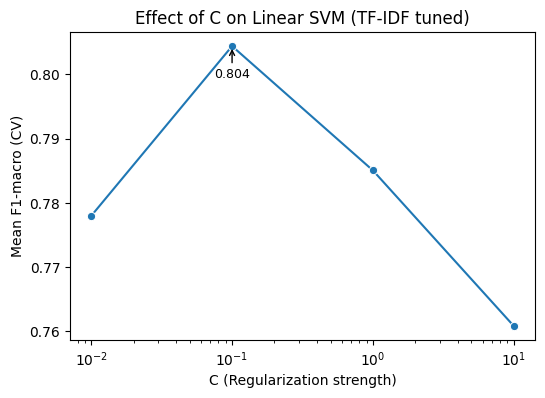

In [31]:
df_svm_cv["C"] = df_svm_cv["params"].apply(lambda x: x["clf__C"])
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=df_svm_cv,
    x="C",
    y="mean_test_score",
    marker="o"
)

best_point = df_svm_cv.loc[df_svm_cv["mean_test_score"].idxmax()]
best_c = best_point["C"]
best_score = best_point["mean_test_score"]

plt.annotate(
    f"{best_score:.3f}",
    xy=(best_c, best_score),
    xytext=(best_c, best_score - 0.005),
    arrowprops=dict(arrowstyle="->"),
    ha="center",
    fontsize=9
)

plt.xscale("log")
plt.xlabel("C (Regularization strength)")
plt.ylabel("Mean F1-macro (CV)")
plt.title("Effect of C on Linear SVM (TF-IDF tuned)")

In [32]:
#Thử trên tập test
svm_tuned_result = evaluate_model(
    grid_svm.best_estimator_,
    X_test,
    y_test
)

In [33]:
df_svm_compare = pd.DataFrame([
    {"Model": "Linear SVM (baseline)", **svm_base_result},
    {"Model": "Linear SVM (tuned)", **svm_tuned_result}
])

df_svm_compare

,Model,Accuracy,F1_macro
0,Linear SVM (baseline),0.807087,0.790323
1,Linear SVM (tuned),0.805118,0.789687


### Naive Bayes Tuning

In [34]:
pipe_nb_base = Pipeline([
    ("tfidf", TfidfVectorizer(**best_tfidf_params)),
    ("clf", MultinomialNB())
])

pipe_nb_base.fit(X_train, y_train)

nb_base_result = evaluate_model(pipe_nb_base, X_test, y_test)

In [35]:
param_grid_nb = {
    "clf__alpha": [0.1, 0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(
    pipe_nb_base,
    param_grid_nb,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)
print(grid_nb.best_score_)

{'clf__alpha': 0.1}
0.7824931242625183


In [36]:
df_nb_cv = pd.DataFrame(grid_nb.cv_results_)
df_nb_cv["alpha"] = df_nb_cv["params"].apply(lambda x: x["clf__alpha"])

df_nb_table = df_nb_cv[
    ["alpha", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("mean_test_score", ascending=False)

df_nb_table

,alpha,mean_test_score,std_test_score,rank_test_score
0,0.1,0.782493,0.018430,1
1,0.5,0.780557,0.019755,2
2,1.0,0.749629,0.010236,3
3,2.0,0.702949,0.009558,4


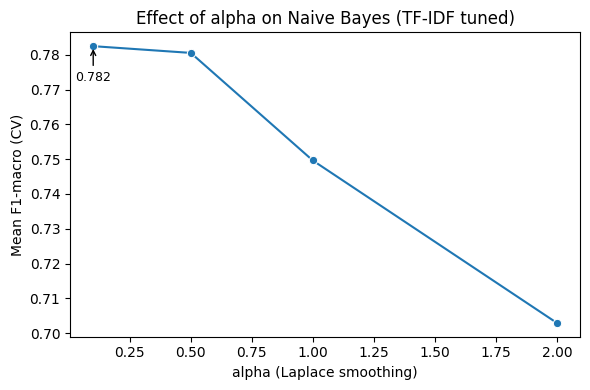

In [37]:
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=df_nb_cv,
    x="alpha",
    y="mean_test_score",
    marker="o"
)
best_point = df_nb_cv.loc[df_nb_cv["mean_test_score"].idxmax()]
best_alpha = best_point["alpha"]
best_score = best_point["mean_test_score"]

plt.annotate(
    f"{best_score:.3f}",
    xy=(best_alpha, best_score),
    xytext=(best_alpha, best_score - 0.01),
    arrowprops=dict(arrowstyle="->"),
    ha="center",
    fontsize=9
)

plt.xlabel("alpha (Laplace smoothing)")
plt.ylabel("Mean F1-macro (CV)")
plt.title("Effect of alpha on Naive Bayes (TF-IDF tuned)")
plt.tight_layout()
plt.show()

In [38]:
nb_tuned_result = evaluate_model(
    grid_nb.best_estimator_,
    X_test,
    y_test
)

In [39]:
df_nb_compare = pd.DataFrame([
    {"Model": "Naive Bayes (baseline)", **nb_base_result},
    {"Model": "Naive Bayes (tuned)", **nb_tuned_result}
])

df_nb_compare

,Model,Accuracy,F1_macro
0,Naive Bayes (baseline),0.802165,0.769051
1,Naive Bayes (tuned),0.785433,0.771898


In [40]:
df_final = pd.concat([
    df_lr_compare[df_lr_compare["Model"].str.contains("tuned")],
    df_svm_compare[df_svm_compare["Model"].str.contains("tuned")],
    df_nb_compare[df_nb_compare["Model"].str.contains("tuned")]
], ignore_index=True)

df_final.sort_values("F1_macro", ascending=False)

,Model,Accuracy,F1_macro
1,Linear SVM (tuned),0.805118,0.789687
0,Logistic Regression (tuned),0.792323,0.779605
2,Naive Bayes (tuned),0.785433,0.771898


In [41]:
df_final_compare = pd.DataFrame([
    {"Model": "Logistic Regression", "Setting": "Baseline", **lr_base_result},
    {"Model": "Logistic Regression", "Setting": "Tuned",    **lr_tuned_result},

    {"Model": "Linear SVM", "Setting": "Baseline", **svm_base_result},
    {"Model": "Linear SVM", "Setting": "Tuned",    **svm_tuned_result},

    {"Model": "Naive Bayes", "Setting": "Baseline", **nb_base_result},
    {"Model": "Naive Bayes", "Setting": "Tuned",    **nb_tuned_result},
])

df_final_compare.sort_values("F1_macro", ascending=False).reset_index(drop=True)

,Model,Setting,Accuracy,F1_macro
0,Linear SVM,Baseline,0.807087,0.790323
1,Linear SVM,Tuned,0.805118,0.789687
2,Logistic Regression,Tuned,0.792323,0.779605
3,Logistic Regression,Baseline,0.792323,0.779605
4,Naive Bayes,Tuned,0.785433,0.771898
5,Naive Bayes,Baseline,0.802165,0.769051


In [42]:
from sklearn.metrics import classification_report

best_svm = pipe_svm_base   # vì baseline tốt hơn tuned

y_pred_svm = best_svm.predict(X_test)

print("=== Linear SVM (Baseline – Best Model) ===")
print(classification_report(y_test, y_pred_svm))

=== Linear SVM (Baseline – Best Model) ===
               precision    recall  f1-score   support

mixed/neutral       0.66      0.67      0.66       247
     negative       0.86      0.86      0.86       368
     positive       0.85      0.85      0.85       401

     accuracy                           0.81      1016
    macro avg       0.79      0.79      0.79      1016
 weighted avg       0.81      0.81      0.81      1016



In [43]:
from sklearn.metrics import confusion_matrix

labels = ["negative", "mixed/neutral", "positive"]

cm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=labels
)


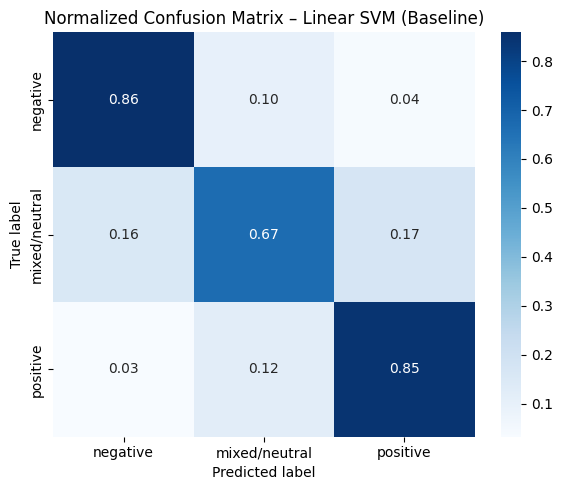

In [44]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Linear SVM (Baseline)")
plt.tight_layout()
plt.show()

Phim nào hay nhất?

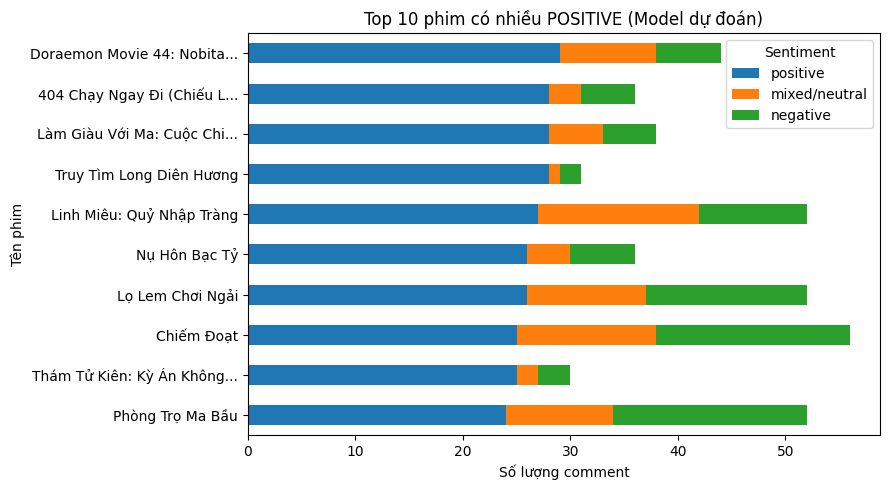

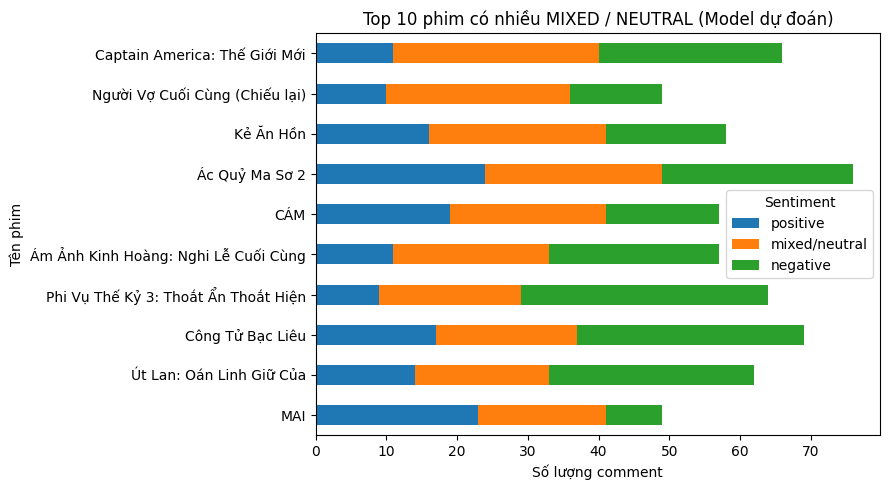

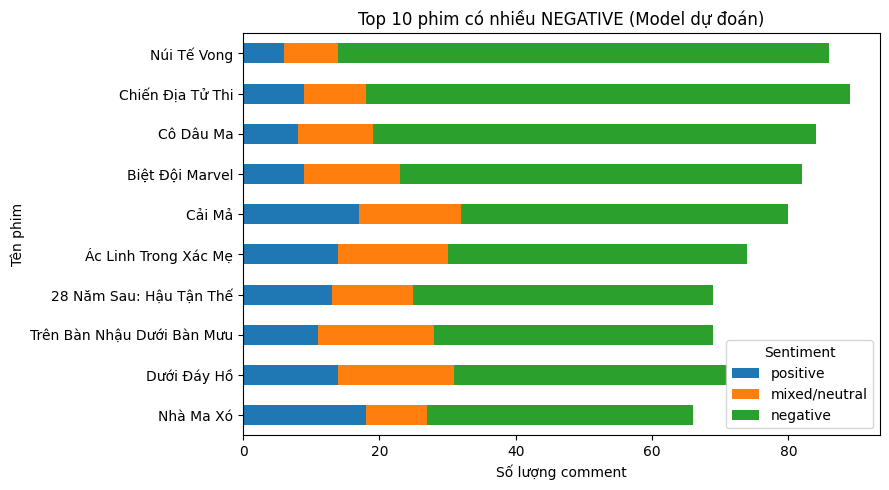

In [67]:
df_pred = df.copy()

df_pred["predicted_label"] = pipe_svm_base.predict(
    df_pred["cleaned_text"]
)

df_count = (
    df_pred
    .groupby(["title", "predicted_label"])
    .size()
    .reset_index(name="count")
)

df_pivot = (
    df_count
    .pivot(index="title", columns="predicted_label", values="count")
    .fillna(0)
    .reset_index()
)

df_pivot["total_comments"] = (
    df_pivot["positive"]
    + df_pivot["mixed/neutral"]
    + df_pivot["negative"]
)

df_pivot = df_pivot[df_pivot["total_comments"] <= 100]

for col in ["positive", "mixed/neutral", "negative"]:
    if col not in df_pivot.columns:
        df_pivot[col] = 0



top_positive = df_pivot.sort_values("positive", ascending=False).head(10)
top_mixed    = df_pivot.sort_values("mixed/neutral", ascending=False).head(10)
top_negative = df_pivot.sort_values("negative", ascending=False).head(10)

def shorten_title(title, max_len=25):
    return title if len(title) <= max_len else title[:max_len] + "..."
top_positive["title"] = top_positive["title"].apply(shorten_title)

def plot_top_movies(df_top, title):
    df_plot = df_top.set_index("title")[["positive", "mixed/neutral", "negative"]]
    
    df_plot.plot(
        kind="barh",
        stacked=True,
        figsize=(9,5)
    )
    
    plt.title(title)
    plt.xlabel("Số lượng comment")
    plt.ylabel("Tên phim")
    plt.gca().invert_yaxis()
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

plot_top_movies(top_positive, "Top 10 phim có nhiều POSITIVE (Model dự đoán)")
plot_top_movies(top_mixed, "Top 10 phim có nhiều MIXED / NEUTRAL (Model dự đoán)")
plot_top_movies(top_negative, "Top 10 phim có nhiều NEGATIVE (Model dự đoán)")